# Forex Rate Prediction - USD/JPY

This example is to predict the foreign exchange rate with Japan.

The data source is from Yahoo Finance.

The data availability is from 30th October 1996 to 31st January 2022.

There are seven columns in the csv files, they are "Date", "Open", "High", "Low", "Close", "Adj Close", "Volume".

Only "Date", "Open", "High", "Low", and "Close" are used for prediction.

## 1. Data Acquisition

In [923]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras

In [924]:
# Reading dataset
forex_dataset = pd.read_csv('Data/Historical forex rate/JPY=X.csv')
forex_dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,30/10/1996,114.370003,114.480003,113.610001,114.180000,114.180000,0.0
1,31/10/1996,NaN,NaN,NaN,NaN,NaN,NaN
2,1/11/1996,113.500000,113.500000,113.500000,113.500000,113.500000,0.0
3,4/11/1996,113.279999,113.980003,112.949997,113.879997,113.879997,0.0
4,5/11/1996,113.709999,114.330002,113.449997,114.250000,114.250000,0.0


## 2. Exploratory Data Analysis

In [925]:
forex_dataset.shape

(6589, 7)

In [926]:
# Checking null values
forex_dataset.isnull().sum()

Date          0
Open         43
High         43
Low          43
Close        43
Adj Close    43
Volume       43
dtype: int64

In [927]:
# Fill NaN values using an interpolation method ("linear")
forex_dataset.interpolate(inplace = True)

In [928]:
# See if there is any difference between the values in "Close" and "Adj Close"
all(forex_dataset['Close']==forex_dataset['Adj Close']) and all(forex_dataset['Volume']<=0)

True

In [929]:
# Drop out the "Adj Close" for redundancy
forex_dataset.drop(['Adj Close','Volume'], axis = 1, inplace = True)

In [930]:
# Resort the date
forex_dataset['Date'] = pd.to_datetime(forex_dataset['Date'], format = '%d/%m/%Y')
forex_dataset.head()

,Date,Open,High,Low,Close
0,1996-10-30,114.370003,114.480003,113.610001,114.180000
1,1996-10-31,113.935001,113.990002,113.555001,113.840000
2,1996-11-01,113.500000,113.500000,113.500000,113.500000
3,1996-11-04,113.279999,113.980003,112.949997,113.879997
4,1996-11-05,113.709999,114.330002,113.449997,114.250000


In [931]:
# See if duplicated row exists
forex_dataset.duplicated().sum()

0

In [932]:
# Set the date to be the index
Date = forex_dataset['Date']
forex_dataset.set_index('Date', inplace= True) 

In [933]:
# Show a summary of the data
forex_dataset.describe()

,Open,High,Low,Close
count,6589.000000,6589.000000,6589.000000,6589.000000
mean,108.613101,109.056737,108.123988,108.608502
std,13.219991,13.301232,13.131916,13.218674
min,75.750000,75.973999,75.570000,75.739998
25%,103.232002,103.699997,102.738998,103.225998
50%,109.804001,110.173668,109.410004,109.821999
75%,117.790001,118.269997,117.286003,117.790001
max,147.339996,147.630005,146.000000,147.220001


Text(0.5, 1.0, 'JPY Exchange Rate at All Time')

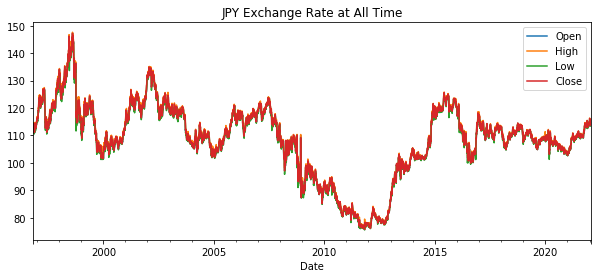

In [934]:
# Plot the Janpanese yen exchange rate
forex_dataset[['Open','High','Low','Close']].plot(figsize = (10,4))
plt.title('JPY Exchange Rate at All Time')

Text(0.5, 0, 'JPY Exchange Rate')

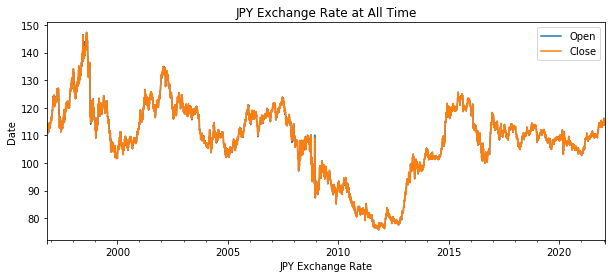

In [935]:
forex_dataset[['Open','Close']].plot(figsize = (10,4))
plt.title('JPY Exchange Rate at All Time')
plt.ylabel('Date')
plt.xlabel('JPY Exchange Rate')

In [1035]:
# Show the correlation of the features
forex_dataset.corr()

,Open,High,Low,Close
Open,1.000000,0.999398,0.999097,0.999018
High,0.999398,1.000000,0.998882,0.999344
Low,0.999097,0.998882,1.000000,0.999383
Close,0.999018,0.999344,0.999383,1.000000


In [1040]:
# Plot the correlation map in another method
forex_dataset.corr().style.background_gradient(cmap='coolwarm').set_precision(4)

,Open,High,Low,Close
Open,1,0.9994,0.9991,0.999
High,0.9994,1,0.9989,0.9993
Low,0.9991,0.9989,1,0.9994
Close,0.999,0.9993,0.9994,1


In [1010]:
# Split the dataset into X and y, with looking back n days of data
# Features of the previous date and the 'Open' of next day are used to predict the closing value of the next day
def get_data(data, look_back): 
    X_data, y_data = [], []
    current_open = []
    for i in range(len(data)-look_back):
        X_data.append(data.iloc[i:(i+look_back),:].values.tolist()[0])
        y_data.append(data.iloc[i+look_back,-1])
        current_open.append(data.iloc[i+look_back,0])
    X_data = [np.append(X, X_open) for X, X_open in zip(X_data, current_open)]
    return np.array(X_data), np.array(y_data).reshape(-1,1)


In [1014]:
# define a function to split the training and testing datasets
from datetime import timedelta
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

def spliting_dataset(forex_dataset, training_end_date):
    # Convert the string type of date into a datetime object, and find the start date for tesing
    date1 = datetime.strptime(training_end_date, '%Y-%m-%d').date()
    if date1.weekday() == 5:
        testing_start_date = str(date1 + timedelta(days = 3))
    else:
        testing_start_date = str(date1 + timedelta(days = 1))
        
    forex_dataset['Date'] = forex_dataset.index
    Dates = forex_dataset[testing_start_date:][['Date']]
    forex_dataset.drop('Date', axis = 1, inplace = True)
    
    # Retrieve the training and testing datasets from forex_dataset
    train_dataset = forex_dataset[:training_end_date]
    test_dataset = forex_dataset[testing_start_date:]
    
    # use the function get_data
    X_train, y_train = get_data(train_dataset, look_back = 2)
    X_test, y_test = get_data(test_dataset, look_back = 2)
    
    # Normalization
    scaler_X = MinMaxScaler()
    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)
    
    scaler_y = MinMaxScaler()
    y_train = scaler_y.fit_transform(y_train)
    y_test = scaler_y.transform(y_test)
    
    # Reshape the 2D-array into 3D-array
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1);
    y_train = y_train.reshape(-1,1,1)
    y_test = y_test.reshape(-1,1,1);
    return (X_train, X_test, y_train, y_test), np.array(Dates).reshape(-1,1), (scaler_X, scaler_y)

(X_train, X_test, y_train, y_test), testing_days, (scaler_X, scaler_y) = spliting_dataset(forex_dataset, training_end_date='2020-12-31')

In [1015]:
# Print the shapes of the training and testing datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((6305, 5, 1), (280, 5, 1), (6305, 1, 1), (280, 1, 1))

## 3. Building the Model

In [648]:
# # Hyperparameter tuning for LSTM
# def tune_architecture(no_of_LSTM_layers, no_of_Dense_layers, no_of_nodes, actication):
#     model = Sequential()
#     for i in range(0, len(no_of_LSTM_layers)):
#         model.add(LSTM(no_of_nodes[i], activation = activation, return_sequences = True, input_shape=(X_train.shape[1],1)))
#         if i >= 0:
#             model.add(LSTM(nodes = no_of_nodes[i], activation = activation, return_sequences = False))
            
#     for i in range(0, len(no_of_Dense_layers)):
#         if i != len(no_of_Dense_layer)-1:
#             model.add(Dense(no_of_nodes[i+len(no_of_LSTM_layers)], activation = activation))
#         elif:
#             model.add(Dense(no_of_nodes[i+len(no_of_LSTM_layers)]))
#     return model

In [995]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import callbacks
model = Sequential()
model.add(LSTM(64, activation = 'relu', return_sequences = False, input_shape=(X_train.shape[1],1)))
# model.add(LSTM(64, activation = 'elu', return_sequences = False))
# model.add(Dense(32, activation='elu'))
model.add(Dense(1))
model.summary()

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_73 (LSTM)              (None, 64)                16896     
                                                                 
 dense_83 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [1016]:
# Compiling
model.compile(optimizer = 'adam', loss = 'mse',metrics=['mse'])

In [1017]:
# Training the model
early_stopping = callbacks.EarlyStopping(min_delta = 0.001, patience= 5, restore_best_weights = True)
model.fit(X_train, y_train, epochs = 10, validation_data = (X_test, y_test), batch_size = 8, callbacks=[early_stopping])

Epoch 1/10
789/789 [==============================] - 9s 8ms/step - loss: 2.0900e-04 - mse: 2.0900e-04 - val_loss: 1.0388e-04 - val_mse: 1.0388e-04
Epoch 2/10
789/789 [==============================] - 6s 8ms/step - loss: 1.9300e-04 - mse: 1.9300e-04 - val_loss: 4.4341e-05 - val_mse: 4.4341e-05
Epoch 3/10
789/789 [==============================] - 6s 8ms/step - loss: 1.7574e-04 - mse: 1.7574e-04 - val_loss: 2.9903e-05 - val_mse: 2.9903e-05
Epoch 4/10
789/789 [==============================] - 6s 7ms/step - loss: 1.7002e-04 - mse: 1.7002e-04 - val_loss: 6.0214e-05 - val_mse: 6.0214e-05
Epoch 5/10
789/789 [==============================] - 6s 7ms/step - loss: 1.5497e-04 - mse: 1.5497e-04 - val_loss: 1.8710e-05 - val_mse: 1.8710e-05
Epoch 6/10
789/789 [==============================] - 7s 8ms/step - loss: 1.4392e-04 - mse: 1.4392e-04 - val_loss: 1.0809e-05 - val_mse: 1.0809e-05


In [1020]:
# The standard deviations
scaler_X.scale_

array([0.01396843, 0.01395556, 0.01419849, 0.01398993, 0.01396843])

In [1021]:
# Prediction using the trained model
y_pred = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)
# Process the test shape
y_test = y_test.reshape(-1,1)
y_test = scaler_y.inverse_transform(y_test)
pd.DataFrame(
  {'pred': y_pred.tolist(),
   'test': y_test.tolist()
}).head(5)

,pred,test
0,[103.77831268310547],[103.125]
1,[103.55648040771484],[102.678001]
2,[103.57380676269531],[103.024002]
3,[103.61189270019531],[103.790001]
4,[103.9922103881836],[104.091003]


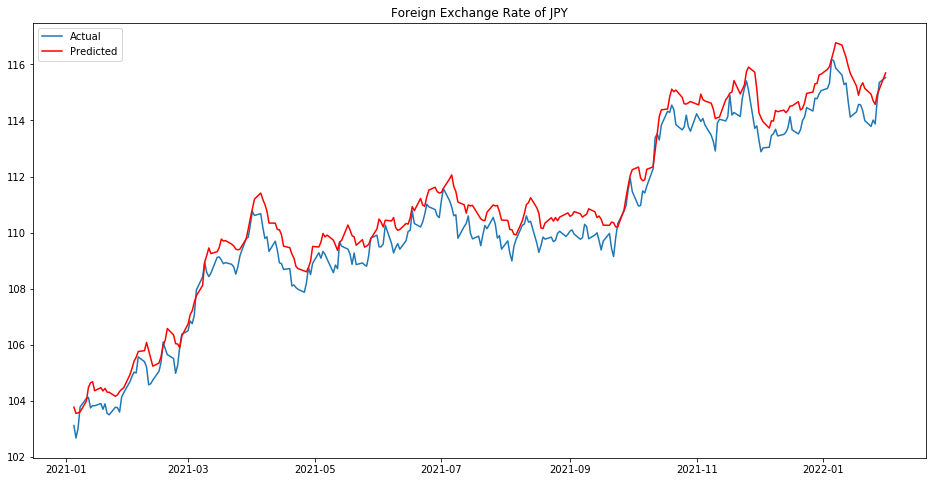

In [1022]:
# Visualize the result
plt.figure(figsize=(16,8))
plt.title('Foreign Exchange Rate of JPY')
plt.plot(testing_days[2:], y_test, label='Actual')
plt.plot(testing_days[2:], y_pred, label='Predicted', color = 'r')
plt.legend()

In [1023]:
# Evalute the result
from sklearn.metrics import mean_squared_error
mse_result = mean_squared_error(y_test, y_pred)
mse_result

0.5307894440314637

In [1024]:
# Record whether the prediction and testing data has an increase or decrease for each testing date
def sign_prediction(y_pred, y_test):
    daily_y_pred_change = []
    daily_y_test_change = []
    daily_complying_sign = []
    y_pred_list = y_pred.reshape(1,-1).tolist()[0]; y_test_list = y_test.reshape(1,-1).tolist()[0]
    for i, pred in enumerate(y_pred_list):
        if pred != y_pred_list[-1]:
            daily_y_pred_change.append(y_pred_list[i+1] - y_pred_list[i])
            daily_y_test_change.append(y_test_list[i+1] - y_test_list[i])

            if (daily_y_pred_change[i] >= 0 and daily_y_test_change[i] >=0) or (daily_y_pred_change[i] < 0 and daily_y_test_change[i] < 0):
                daily_complying_sign.append(1)
            else:
                daily_complying_sign.append(0)
    return daily_y_pred_change, daily_y_test_change, daily_complying_sign

In [1025]:
daily_y_pred_change, daily_y_test_change, daily_complying_sign = sign_prediction(y_pred, y_test)
# 1 denotes as predicted corrected for the change of sign, while 0 means the opposite
daily_complying_sign.count(1)/len(daily_complying_sign)

0.5842293906810035

In [1026]:
pd.DataFrame(
  {'pred': daily_y_pred_change,
   'test': daily_y_test_change
}).tail(20)

,pred,test
259,0.099129,0.186005
260,0.268822,0.846001
261,0.276649,-0.046006
262,0.305283,-0.263000
263,-0.082932,-0.247002
264,-0.221634,-0.339996
265,-0.226837,0.053001
266,-0.303764,-0.655998
267,-0.252953,-0.557007
268,-0.459747,0.188004


In [1032]:
daily_y_pred_change2, daily_y_test_change2, daily_complying_sign2 = sign_prediction(y_pred[2:], y_test[:-2])
daily_complying_sign2.count(1)/len(daily_complying_sign2)

0.8086642599277978

In [1033]:
pd.DataFrame(
  {'pred': daily_y_pred_change2,
   'test': daily_y_test_change2
}).tail(20)

,pred,test
257,0.099129,0.115006
258,0.268822,0.078994
259,0.276649,0.186005
260,0.305283,0.846001
261,-0.082932,-0.046006
262,-0.221634,-0.263000
263,-0.226837,-0.247002
264,-0.303764,-0.339996
265,-0.252953,0.053001
266,-0.459747,-0.655998


# Predictions for monthly Consecutive Days 

In [662]:
str(today)

'2022-02-03'

In [688]:
today = date.today()
def monthly_prediction(forex_dataset, training_end_date):
    X_train, X_test, y_train, y_test, testing_days= spliting_dataset(forex_dataset, training_end_date)
    
    model = Sequential()
    model.add(LSTM(3, activation = 'elu', return_sequences = False, input_shape=(X_train.shape[1],1), dropout=0.4, recurrent_dropout=0.4))
    # model.add(LSTM(64, activation = 'elu', return_sequences = False, dropout=0.2, recurrent_dropout=0.2))
    # model.add(Dense(32, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer = 'adam', loss = 'mse',metrics=['acc'])
    early_stopping = callbacks.EarlyStopping(min_delta = 0.0001, patience= 5, restore_best_weights = True)
    model.fit(X_train, y_train, epochs = 1000, validation_data = (X_test, y_test), batch_size = 3, callbacks=[early_stopping])
    y_pred = model.predict(X_test)
    y_test = y_test.reshape(-1,1)
    mse_result = mean_squared_error(y_test, y_pred)
    

    return model, mse_result, (sign_prediction(y_pred, y_test)), testing_days

mon_model, mon_mse_result, (daily_pred_change, daily_test_change, sign_change), testing_days = monthly_prediction(forex_dataset, '2020-12-31')

Epoch 1/10
789/789 [==============================] - 36s 29ms/step - loss: 1329.7781 - acc: 0.0000e+00 - val_loss: 178.7909 - val_acc: 0.0000e+00
Epoch 2/10
789/789 [==============================] - 20s 25ms/step - loss: 670.2453 - acc: 0.0000e+00 - val_loss: 73.9750 - val_acc: 0.0000e+00
Epoch 3/10
789/789 [==============================] - 18s 23ms/step - loss: 611.5733 - acc: 0.0000e+00 - val_loss: 237.6265 - val_acc: 0.0000e+00
Epoch 4/10
789/789 [==============================] - 21s 26ms/step - loss: 563.5494 - acc: 0.0000e+00 - val_loss: 1.0031 - val_acc: 0.0000e+00s - loss: 564.3519 - acc: 0.0000e+
Epoch 5/10
789/789 [==============================] - 18s 23ms/step - loss: 514.4771 - acc: 0.0000e+00 - val_loss: 43.0984 - val_acc: 0.0000e+00
Epoch 6/10
789/789 [==============================] - 20s 25ms/step - loss: 505.5531 - acc: 0.0000e+00 - val_loss: 16.3860 - val_acc: 0.0000e+00 - acc: 0.000 - ETA: 2s -
Epoch 7/10
789/789 [==============================] - 19s 24ms/step -

In [684]:
sign_change.count(1)/len(sign_change)

0.6071428571428571

In [1027]:
pd.DataFrame(
    {'y_pred_change': _,
     'y_test_change': __
    }).head(10)

,y_pred_change,y_test_change
0,-0.069206,-0.113998
1,-0.056694,-0.446999
2,-0.118065,0.346001
3,0.282532,0.765999
4,0.398575,0.301002
5,0.228722,0.036995
6,0.012398,-0.375999
7,-0.287621,0.084999
8,0.091339,-0.008995
9,-0.070618,0.079994


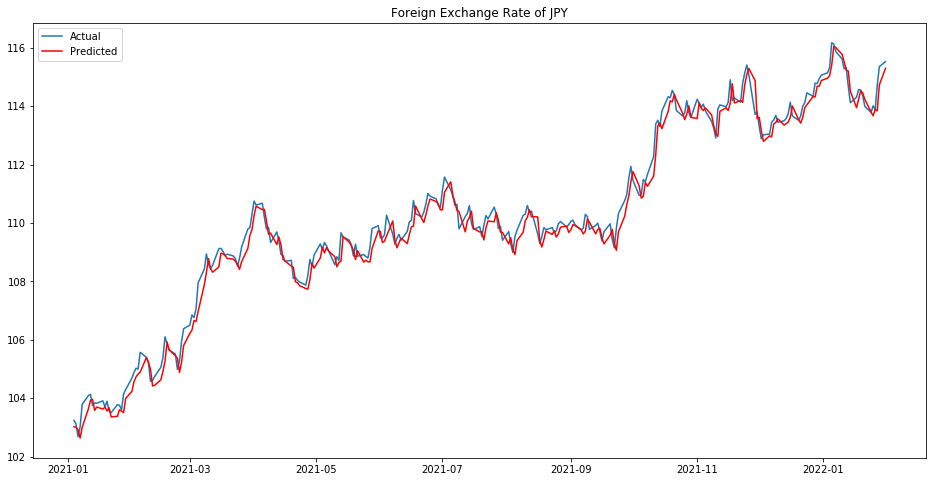

In [677]:
# Visualize the result
plt.figure(figsize=(16,8))
plt.title('Foreign Exchange Rate of JPY')
plt.plot(testing_days[1:], mon_y_test, label='Actual')
plt.plot(testing_days[1:], mon_y_pred, label='Predicted', color = 'r')
plt.legend()

# Writing result to Excel file

In [ ]:
# Writing result to an Excel file
from openpyxl import load_workbook
filename_result = 'Result/Forex Prediction Result.xlsx'
wb_result = load_workbook(filename_result)
ws_result = wb_result.worksheets[0]

# Title
ws_result['A1'] = 'Analysis Date'
ws_result['B1'] = 'Testing period'
ws_result['C1'] = 'LSTM Architecture' 
ws_result['D1'] = 'MSE Result'

for i in range(1,10000):
    if ws_result['A'+str(i+1)] != '':
        ws_result['A'+str(i+1)] = today
wb_result.save(filename_result)

In [ ]:
from datetime import date

today = date.today()
print("Today's date:", today)